In [1]:
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, '../')
from transform_attention_weights_lib import transform_attention_weights
from aggregation_sentence_information_lib import aggregate_weight_information_for_sentences

In [2]:
import scipy.stats as stats

In [3]:
arne=False
lautaro_and_fabi=False
server=True

if arne:
    weights = np.load(r"E:\graphsum\data\attention_weights_with_meta_information\pretrained_attention_weights.npy")
    parent_idx = np.load(r"E:\graphsum\data\attention_weights_with_meta_information\parent_idx.npy")
    scores = np.load(r"E:\graphsum\data\attention_weights_with_meta_information\scores.npy")
    result_dict = pickle.load(open(r"E:\graphsum\data\attention_weights_with_meta_information\save_dict" ,"rb"))
elif lautaro_and_fabi:
    weights = np.load("./data/attention_weights/pretrained_attention_weights.npy")
    parent_idx = np.load("./data/attention_weights/parent_idx.npy")
    scores = np.load("./data/attention_weights/scores.npy")
    result_dict = pickle.load(open("./data/attention_weights/save_dict" ,"rb"))
elif server:
    weights_list = []
    scores_list = []
    result_dicts_list = []
    for i in range(13):
        weights = np.load("/home/lochner/RQ2/GBTBMDS/saved_attention_weights/pretrained_attention_weights_%s.npy"  % str(i))
        parent_idx = np.load("/home/lochner/RQ2/GBTBMDS/saved_attention_weights/parent_idx_%s.npy" % str(i) )
        scores = np.load("/home/lochner/RQ2/GBTBMDS/saved_attention_weights/scores_%s.npy"  % str(i))
        result_dicts = pickle.load(open("/home/lochner/RQ2/GBTBMDS/saved_attention_weights/save_dict_%s" % str(i) ,"rb"))

        result_dicts["beam_length"] = np.where(result_dicts["beam_length"] < 301, result_dicts["beam_length"], 300)
        result_dicts["longest_beam_array"] = np.where(result_dicts["longest_beam_array"] < 301, result_dicts["longest_beam_array"], 300)

        
        cleaned_weight_matrix, cleaned_score_matrix = transform_attention_weights(weights, parent_idx, scores, result_dicts)
        weights_list.append(cleaned_weight_matrix)
        result_dicts_list.append(result_dicts)
        scores_list.append(cleaned_score_matrix)
    
    cleaned_weight_matrix = np.concatenate(weights_list)
    cleaned_score_matrix = np.concatenate(scores_list)
   

result_dict = dict()
for key in ['longest_beam_array', 'data_ids', 'summary_beam_list', 'number_of_textual_units', 'scores_array', 'token_beam_array', 'beam_length']:
    
    result_dict[key] = np.concatenate([result_dicts_list[i][key] for i in range(13)])


In [4]:
r = pickle.load(open("../r.p", "rb"))

In [5]:
def prepare_input(input_matrix, meta_information):
    
    decoding_layers = [[] for i in range(8)]
    
    multi_heads = [[] for i in range(8)]
    
    num_examples = input_matrix.shape[0]
    
    for idx in range(num_examples):
        beam_length = meta_information[idx][0]
        
        
        ex = input_matrix[idx,0,:int(beam_length-1),:,:,:]
              
       
        
        for j in range(8):
            decoding_layers[j].extend(ex[:,j,:,:].reshape(-1,))
            multi_heads[j].extend(ex[:,:,j,:].reshape(-1,))
            
    return decoding_layers, multi_heads
        
        

In [6]:
def prepare_input_spearmanr(input_matrix, meta_information):
    
    decoding_layers = [[] for i in range(8)]
    
    multi_heads = [[] for i in range(8)]
    
    num_examples = input_matrix.shape[0]
    
    for idx in range(num_examples):
        beam_length = meta_information[idx][0]
        
        
        ex = input_matrix[idx,0,:int(beam_length-1),:,:,:]
        
       
        
        for j in range(8):
            decoding_layers[j].extend(
                (np.argsort(np.argsort(ex[:,j,:,:])) + 1).reshape(-1,)
            )
            multi_heads[j].extend((np.argsort(np.argsort(ex[:,:,j,:])) + 1).reshape(-1,))
            
    return decoding_layers, multi_heads
        
        

In [7]:
d_test, m_test = prepare_input_spearmanr(cleaned_weight_matrix[:,0,:,:,:,:][:,None,:,:,:,:], result_dict["beam_length"][:,0][:,None])

In [18]:
def calculate_correlation(multi_heads, decoding_layers):    
        
    multi_head_corr = np.corrcoef(multi_heads)
    
    decoding_layers_corr = np.corrcoef(decoding_layers)
    
    print(f"Multi-Head: mean {np.mean(multi_head_corr)} | min {np.min(multi_head_corr)} ")
    
    plt.figure()
    plt.imshow(multi_head_corr)
    plt.colorbar()
    plt.savefig("multi_head_corr.pdf")
    plt.show()
    
    print(f"Decoding-Layer: mean {np.mean(decoding_layers_corr)} | min {np.min(decoding_layers_corr)} ")
    
    plt.figure()
    plt.imshow(decoding_layers_corr)
    plt.colorbar()
    plt.savefig("decoding_layer_corr.pdf")
    plt.show()
    
    

    
    return multi_head_corr, decoding_layers_corr

def calculate_correlation_with_threshold(multi_heads, decoding_layers, threshold):
    
    multi_head_corr = np.ones(shape=[8,8])
    decoding_layers_corr = np.ones(shape=[8,8])
    
    for i in range(8):
        for j in range(8):
            if i == j:
                break
            head_0_index = np.where(np.array(multi_heads[i]) > threshold)
            head_1_index = np.where(np.array(multi_heads[j]) > threshold)
            
            complete_head_index = head_0_index + head_1_index 

            
            decoding_0_index = np.where(np.array(decoding_layers[i]) > threshold)
            decoding_1_index = np.where(np.array(decoding_layers[j]) > threshold)
            
            decoding_complete_index = decoding_0_index + decoding_1_index

            
            multi_head_corr[i,j] = np.corrcoef(np.array(multi_heads[i])[np.concatenate(complete_head_index)], np.array(multi_heads[j])[np.concatenate(complete_head_index)])[0,1]
            
            multi_head_corr[j,i] = multi_head_corr[i,j]
            
            decoding_layers_corr[i,j] = np.corrcoef(np.array(decoding_layers[i])[np.concatenate(decoding_complete_index)], np.array(decoding_layers[j])[np.concatenate(decoding_complete_index)])[0,1]
            
            decoding_layers_corr[j,i] = decoding_layers_corr[i,j]
    
    
    print(f"Multi-Head: mean {np.mean(multi_head_corr)} | min {np.min(multi_head_corr)} ")
    
    plt.figure()
    plt.imshow(multi_head_corr)
    plt.colorbar()
    plt.show()
    
    print(f"Decoding-Layer: mean {np.mean(decoding_layers_corr)} | min {np.min(decoding_layers_corr)} ")
    
    plt.figure()
    plt.imshow(decoding_layers_corr)
    plt.colorbar()
    plt.show()
    
    
    
    return multi_head_corr, decoding_layers_corr
    
    

In [9]:
def calculate_spearman_correlation(multi_heads, decoding_layers):    
    
    multi_head_corr = stats.spearmanr(multi_heads,axis=1)[0]
    
    decoding_layers_corr = stats.spearmanr(decoding_layers,axis=1)[0]
    
    print(f"Multi-Head: mean {np.mean(multi_head_corr)} | min {np.min(multi_head_corr)} ")
    
    plt.figure()
    plt.imshow(multi_head_corr, vmin=0.5, vmax=1)
    plt.colorbar()
    plt.show()
    
    print(f"Decoding-Layer: mean {np.mean(decoding_layers_corr)} | min {np.min(decoding_layers_corr)} ")
    
    plt.figure()
    plt.imshow(decoding_layers_corr, vmin=0.5, vmax=1)
    plt.colorbar()
    plt.show()
    
    
    
    return multi_head_corr, decoding_layers_corr
    

Multi-Head: mean 0.644932933692702 | min 0.5143584815372538 


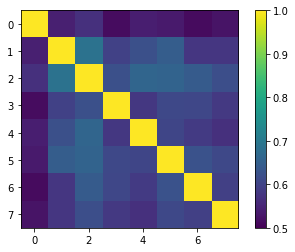

Decoding-Layer: mean 0.5937258047885751 | min 0.41859288926696697 


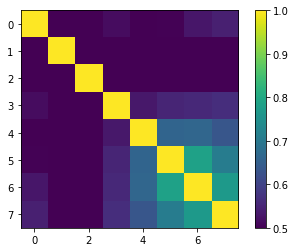

In [10]:
m_spear, d_spear = calculate_spearman_correlation(m_test, d_test)

In [11]:
token_decoding,token_multi_head  = prepare_input(cleaned_weight_matrix[:,0,:,:,:,:][:,None,:,:,:,:], result_dict["beam_length"][:,0][:,None])

Multi-Head: mean 0.6572274947101049 | min 0.3807323756099385 


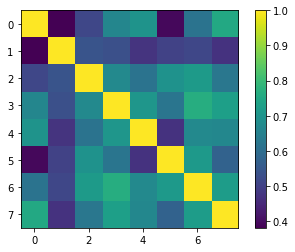

Decoding-Layer: mean 0.3471897196612951 | min 0.027742558663394278 


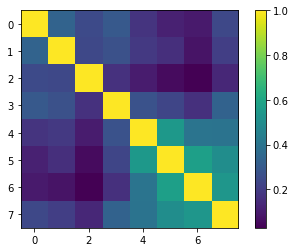

In [12]:
t_m,t_d = calculate_correlation_with_threshold(token_multi_head, token_decoding, 0.05)

Multi-Head: mean 0.7192955274934009 | min 0.4911719322340138 


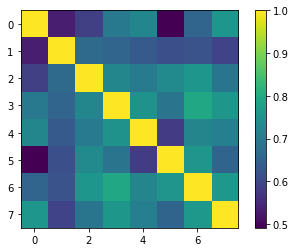

Decoding-Layer: mean 0.5365844539681838 | min 0.2439005529791923 


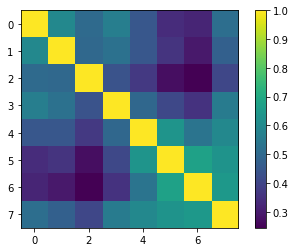

In [19]:
t_m,t_d = calculate_correlation(token_multi_head, token_decoding)